In [1]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pickle
import numpy as np
import tensorflow as tf

In [2]:
# reset graph for re run
tf.reset_default_graph()

# random seeds
np.random.seed(42)
tf.set_random_seed(42)

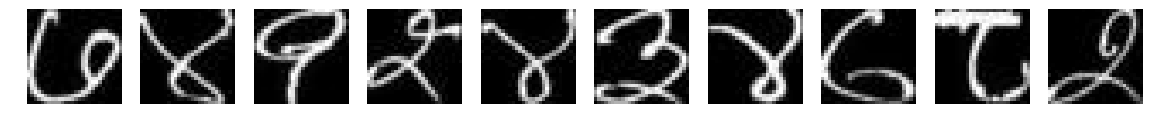

In [3]:
# Dataset load and visualization
pickle_in = open("hicr_data.pickle", "rb")
digits = pickle.load(pickle_in)

# Plot
n_samples = 10

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = digits["train"]["data"][index*10].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [4]:
# Input Images
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

In [5]:
# PRIMARY CAPSULES
##################
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6
caps1_n_dims = 8

conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
print(conv1)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)
print(conv2)

Tensor("conv1/Relu:0", shape=(?, 20, 20, 256), dtype=float32)
Tensor("conv2/Relu:0", shape=(?, 6, 6, 256), dtype=float32)


In [6]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")
print(caps1_raw)

Tensor("caps1_raw:0", shape=(?, 1152, 8), dtype=float32)


In [7]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector
    
caps1_output = squash(caps1_raw, name="caps1_output")
print(caps1_output)

Tensor("caps1_output/mul:0", shape=(?, 1152, 8), dtype=float32)


In [8]:
# DIGIT CAPSULES
################
caps2_n_caps = 4
caps2_n_dims = 16

init_sigma = 0.01

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

In [9]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 4, 16, 8) dtype=float32>

In [10]:
caps1_output_tiled

<tf.Tensor 'caps1_output_tiled:0' shape=(?, 1152, 4, 8, 1) dtype=float32>

In [11]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 4, 16, 1) dtype=float32>

In [12]:
# ROUTING AGREEMENT
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

# ROUND 1
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")
# ROUND 2
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")
caps2_output = caps2_output_round_2

In [13]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])
    

with tf.Session() as sess:
    print(sess.run(result))

(328350, 100)


In [14]:
sum([i**2 for i in range(1, 100 + 1)])

338350

In [15]:
# Estimated Class Probabilities
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)
    
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [16]:
# Output
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

In [17]:
# Loss
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

T = tf.one_hot(y, depth=caps2_n_caps, name="T")

with tf.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]


In [18]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 4),
                           name="present_error")

absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 4),
                          name="absent_error")

L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

In [19]:
# RECONSTRUCTION
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

In [20]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [21]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

In [22]:
# DECODER
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

In [23]:
# LOSS
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_sum(squared_difference,
                                    name="reconstruction_loss")

alpha = 0.0005
loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

In [24]:
# Touches
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [25]:
# TRAINING
n_epochs = 5
batch_size = 50
restore_checkpoint = True

n_iterations_per_epoch = len(digits["train"]["data"]) // batch_size
n_iterations_validation = len(digits["valid"]["data"]) // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        iter_start_index = 0
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch = digits["train"]["data"][iter_start_index: iter_start_index+batch_size]
            y_batch = digits["train"]["labels"][iter_start_index: iter_start_index+batch_size]
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch,
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")
            iter_start_index = iter_start_index+batch_size

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        iter_start_index = 0
        for iteration in range(1, n_iterations_validation + 1):
            X_batch = digits["valid"]["data"][iter_start_index: iter_start_index+batch_size]
            y_batch = digits["valid"]["labels"][iter_start_index: iter_start_index+batch_size]
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch,
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
            iter_start_index = iter_start_index+batch_size
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1  Val accuracy: 25.3333%  Loss: 2.335388 (improved)
Epoch: 2  Val accuracy: 27.5556%  Loss: 2.136701 (improved)
Epoch: 3  Val accuracy: 33.1111%  Loss: 1.925237 (improved)
Epoch: 4  Val accuracy: 36.0000%  Loss: 1.875037 (improved)
Epoch: 5  Val accuracy: 37.7778%  Loss: 1.822927 (improved)


In [39]:
# PREDICTION
n_samples = 10

X_batch = digits["test"]["data"][: n_samples]
y_batch = digits["test"]["labels"][: n_samples]

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: X_batch,
                           y: y_batch,
                           mask_with_labels: True})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


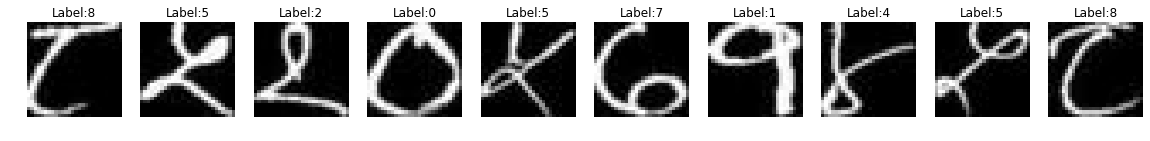

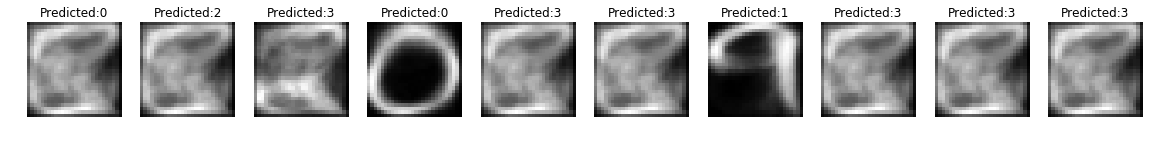

In [40]:
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(digits["test"]["data"][index].reshape(28, 28), cmap="binary")
    plt.title("Label:" + str(digits["test"]["labels"][index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()